# Reddit Post Classifier

# Step 1: Data Cleaning

We started with two sources of data from Kaggle: 
1. table of 3394 subreddits, categorized
2. table of 1,033,000 text posts from 1,033 subreddits (1000 posts per subreddit)

All data is from 2016/06/01 to 2018/06/01.


In [2]:
import pandas as pd

In [3]:
subreddits = pd.read_csv('subreddit_info.csv')
subreddits.head()

FileNotFoundError: [Errno 2] File b'subreddit_info.csv' does not exist: b'subreddit_info.csv'

### Cleaning Dataset 1 [subreddits]: only kept rows "in_data" and kept relevant columns

In [128]:
subreddits = subreddits[subreddits['in_data'] == True]
subreddits = subreddits.drop(['reason_for_exclusion', 'category_2', 'category_3', 'in_data'], axis = 1)

In [129]:
arts = subreddits[subreddits['category_1']=='arts']
programming = subreddits[subreddits['category_1']=='programming']

In [130]:
arts

,subreddit,category_1
162,3Dprinting,arts
163,animation,arts
165,AutoDetailing,arts
172,characterdrawing,arts
173,cinematography,arts
180,drawing,arts
189,tabletopgamedesign,arts
190,graphic_design,arts
192,lasercutting,arts
194,Leathercraft,arts


### Cleaning Dataset 2 [posts]: we wanted to only keep the text data from the relevant subreddits and save that as cleaned data

In [5]:
posts = pd.read_csv('rspct.tsv', sep='\t')

In [6]:
posts.head()

,id,subreddit,title,selftext
0,6d8knd,talesfromtechsupport,Remember your command line switches...,"Hi there, <lb>The usual. Long time lerker, fi..."
1,58mbft,teenmom,"So what was Matt ""addicted"" to?",Did he ever say what his addiction was or is h...
2,8f73s7,Harley,No Club Colors,Funny story. I went to college in Las Vegas. T...
3,6ti6re,ringdoorbell,"Not door bell, but floodlight mount height.",I know this is a sub for the 'Ring Doorbell' b...
4,77sxto,intel,Worried about my 8700k small fft/data stress r...,"Prime95 (regardless of version) and OCCT both,..."


In [7]:
arts_subreddit_list = list(arts['subreddit'])
programming_subreddit_list = list(programming['subreddit'])

In [8]:
arts_list = [posts[posts['subreddit'] == subreddit] for subreddit in arts_subreddit_list]
arts_posts = pd.concat(arts_list)

programming_list = [posts[posts['subreddit'] == subreddit] for subreddit in programming_subreddit_list]
programming_posts = pd.concat(programming_list)


#### Adding labels: 0 for Arts, 1 for Programming

In [9]:
arts_posts['label'] = 0
programming_posts['label'] = 1

In [10]:
raw = pd.concat([arts_posts, programming_posts]).reset_index().drop(['index', 'id'], axis=1)


#### Combining 'title' and 'selftext' into a single string

In [11]:
raw['text'] = raw['title'] + " " + raw['selftext']

In [12]:
posts = raw.drop(['title', 'selftext', 'subreddit'], axis=1)

In [13]:
posts.head()

,label,text
0,0,Modelling and printing help I have a friend th...
1,0,Prusa i3 Hot end problem The hot end for my 3D...
2,0,Is there a website or gallery showcasing all o...
3,0,Did I blow the mosfet? I just set up my ramps ...
4,0,"Setup help? Hey guys, I have a raspberry pi wi..."


In [14]:
posts.to_csv('arts-programming-reddit-posts.csv') # our cleaned data csv

# Step 2: Data Preprocessing/Feature Engineering

In [6]:
posts = pd.read_csv('~/data/arts-programming-reddit-posts.csv', index_col = None).drop('Unnamed: 0', axis=1)

FileNotFoundError: [Errno 2] File b'/Users/yshuenlim/data/arts-programming-reddit-posts.csv' does not exist: b'/Users/yshuenlim/data/arts-programming-reddit-posts.csv'

###  Tokenize, lemmatize, filter out non-English words

In [1]:
import pandas as pd
import nltk
import sklearn

from nltk.collocations import *
from nltk.corpus import stopwords
# from nltk.stem import *
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
wordnet_lemmatizer = WordNetLemmatizer()
english = set(nltk.corpus.words.words())

In [3]:
def lemmadata(doc):
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
    raw_tokens = nltk.regexp_tokenize(doc, pattern)
    tokens = [i.lower() for i in raw_tokens]
    stop_words = set(stopwords.words('english'))
    listed = [w for w in tokens if not w in stop_words]
    lemmatized = [wordnet_lemmatizer.lemmatize(word, pos="v") for word in listed]
    lemmatized = list(filter(lambda w: w != 'lb', lemmatized))
    words = list(filter(lambda w: w in english, lemmatized))
    return " ".join(words)


In [4]:
lemmatized = pd.DataFrame([lemmadata(post) for post in list(posts['selftext'])])

In [ ]:
vec = CountVectorizer()
X = vec.fit_transform(lemmatized)
df = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())


In [ ]:
df.shape

(42000, 19380)

### Feature Selection
We end up with 19,380 unique words, so we get rid of sparse columns.
- look at word count
- look at TF-IDF scores

First we inspect data to see the frequencies of words.

In [ ]:
unique_words = list(df.columns.values)

In [ ]:
word_sums = [(word, df[word].sum()) for word in unique_words]


In [ ]:
from operator import itemgetter
word_sums.sort(key=itemgetter(1), reverse=True)


In [ ]:
word_sums[10]

('need', 15757)

In [ ]:
df.head()

,aa,aam,aba,abac,aback,abandon,abandonment,abb,abbey,abbreviate,...,zombie,zonal,zone,zoo,zoologist,zoom,zoon,zooplankton,zorro,zowie
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We did a test to see how many unique words we'd have left after filtering out the words with low count across all posts.

- over 1 occurrence: 15,000+ words
- over 10 occurrences: 7,000+ words

So we decide to filter out based on TF-IDF scores, to weight words by importance to post. Upon inspecting TF-IDF values, we chose a threshold of 0.0001 by looking at the values of words that didn't make sense. i.e. 'abcdefghijklmnopqrstuvwxyz'.

#### Word vectorizing with TF-IDF scores

In [87]:
from sklearn.feature_extraction.text import TfidfVectorizer


In [88]:
tfidf = TfidfVectorizer()

In [ ]:
response = tfidf.fit_transform(lemmatized)


In [ ]:
tfidf_df = pd.DataFrame(response.toarray(), columns=tfidf.get_feature_names())

In [ ]:
tfidf_df.head()

,aa,aam,aba,abac,aback,abandon,abandonment,abb,abbey,abbreviate,...,zombie,zonal,zone,zoo,zoologist,zoom,zoon,zooplankton,zorro,zowie
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Keeping only words with average TF-IDF scores over 0.0001

In [ ]:
relevant = []
for word in unique_words:
    if tfidf_df[word].mean() > 0.0001:
        relevant.append(tfidf_df[word])
len(relevant)

4910

In [ ]:
relevant_df = pd.DataFrame(relevant).transpose()
relevant_df.head()

,aa,abandon,ability,able,abort,abroad,absolute,absolutely,absorb,abstract,...,young,younger,youth,yr,za,zero,zip,zipper,zone,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Saving this ready-to-model data as a new csv

In [ ]:
relevant_df.to_csv('cleaned-data.csv')

## Visualizing Our Data

In [91]:
x = pd.read_csv('cleaned-data.csv').drop('Unnamed: 0', axis=1)

In [7]:
posts = pd.read_csv('arts-programming-reddit-posts.csv')
y = posts.label

In [92]:
unique_relevant_words = list(x.columns.values)

#### Reducing dimensionality from 4910 to 2 and 3 so we can plot our data on graphs

In [8]:
from sklearn.decomposition import PCA
pca2 = PCA(n_components=2)
pca2.fit(x)
x2_pca = pca2.transform(x)
x2_pca = pd.DataFrame(x2_pca)

pca3 = PCA(n_components=3)
pca3.fit(x)
x3_pca = pca3.transform(x)
x3_pca = pd.DataFrame(x3_pca)

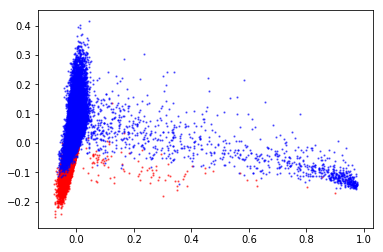

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(x2_pca[0][:21000], x2_pca[1][:21000], s=1.5, alpha = 0.5, c = 'red')
plt.scatter(x2_pca[0][21001:], x2_pca[1][21001:], s=1.5, alpha = 0.5, c = 'blue')

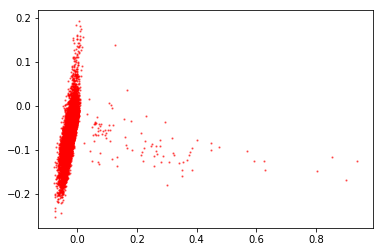

In [10]:
plt.scatter(x2_pca[0][:21000], x2_pca[1][:21000], s=1.5, alpha = 0.5, c = 'red')

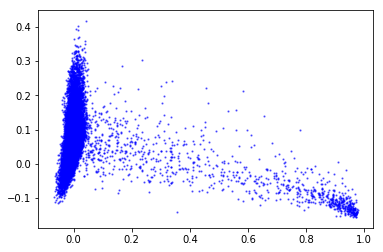

In [11]:
plt.scatter(x2_pca[0][21001:], x2_pca[1][21001:], s=1.5, alpha = 0.5, c = 'blue')

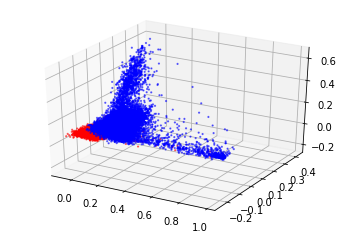

In [12]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x3_pca[0][:21000], x3_pca[1][:21000], x3_pca[2][:21000], s=1.5, alpha = 0.5, c = 'red')
ax.scatter(x3_pca[0][21001:], x3_pca[1][21001:], x3_pca[2][21001:], s=1.5, alpha = 0.5, c = 'blue')

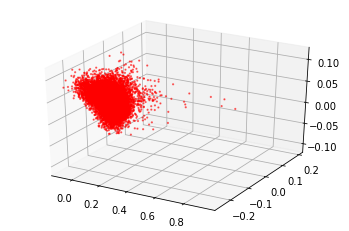

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x3_pca[0][:21000], x3_pca[1][:21000], x3_pca[2][:21000], s=1.5, alpha = 0.5, c = 'red')

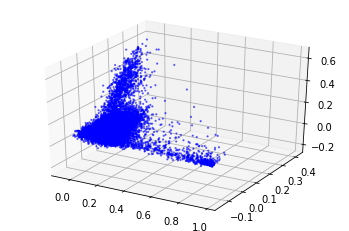

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x3_pca[0][21001:], x3_pca[1][21001:], x3_pca[2][21001:], s=1.5, alpha = 0.5, c = 'blue')

# Step 3: Fitting and Evaluating Different Models
We want to test a bunch of different models on our data to see which is best for classification.
1. KNN
2. Decision Tree
3. Random Forest
4. Bagged Trees
5. AdaBoost
6. Gradient Boost
7. Multinomial Naive Bayes
8. Support Vector Machine (+ PCA!)

In [15]:
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

In [16]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

### We initialize a new dataframe to store our results.

In [78]:
results = pd.DataFrame()

In [18]:
def evaluate(test, pred, model):
    return [model, precision_score(test, pred), recall_score(test, pred), accuracy_score(test, pred), f1_score(test, pred)]

In [19]:
def print_metrics(labels, preds):
    print("Precision Score: {}".format(precision_score(labels, preds)))
    print("Recall Score: {}".format(recall_score(labels, preds)))
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("F1 Score: {}".format(f1_score(labels, preds)))

## a. K Nearest Neighbors

In [20]:
from sklearn.neighbors import KNeighborsClassifier

In [21]:
# Find optimal f1 score
def find_best_k(X_train, y_train, X_test, y_test, min_k=1, max_k=25):
    best_k = 0
    best_score = 0.0
    for k in range(min_k, max_k+1, 2):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        preds = knn.predict(X_test)
        f1 = f1_score(y_test, preds)
        if f1 > best_score:
            best_k = k
            best_score = f1
    
    print("Best Value for k: {}".format(best_k))
    print("F1-Score: {}".format(best_score))

In [22]:
# find_best_k(x_train, y_train, x_test, y_test)

We found that the best scores are when **k=1**.

In [23]:
start = time.time()
knn_classifier = KNeighborsClassifier(n_neighbors=1)
knn_classifier.fit(x_train, y_train)
knn_runtime = time.time() - start

In [24]:
knn_pred = knn_classifier.predict(x_test)
print_metrics(y_test, knn_pred)

Precision Score: 0.5901039379300249
Recall Score: 0.9710913033004095
Accuracy Score: 0.6523809523809524
F1 Score: 0.7341103624112183


In [25]:
pd.crosstab(y_test, knn_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,1449,2800,4249
1,120,4031,4151
All,1569,6831,8400


In [26]:
a = evaluate(y_test, knn_pred, 'K Nearest Neighbors')

## b. Decision Tree

In [27]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree 

In [28]:
start = time.time()
dt_classifier = DecisionTreeClassifier()  
dt_classifier.fit(x_train, y_train) 
dt_runtime = time.time() - start

In [29]:
dt_pred = dt_classifier.predict(x_test)  
print_metrics(y_test, dt_pred)

Precision Score: 0.8995974425763675
Recall Score: 0.915201156347868
Accuracy Score: 0.9076190476190477
F1 Score: 0.9073322187723907


In [30]:
pd.crosstab(y_test, dt_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,3825,424,4249
1,352,3799,4151
All,4177,4223,8400


In [31]:
b = evaluate(y_test, dt_pred, 'Decision Tree')

## c. Random Forest

In [32]:
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier

In [33]:
start = time.time()
rf_classifier = RandomForestClassifier(n_estimators=100)
rf_classifier.fit(x_train, y_train)
rf_runtime = time.time() - start

In [34]:
rf_pred = rf_classifier.predict(x_test)  
print_metrics(y_test, rf_pred)

Precision Score: 0.9567915970398663
Recall Score: 0.9655504697663214
Accuracy Score: 0.9614285714285714
F1 Score: 0.9611510791366907


In [35]:
pd.crosstab(y_test, rf_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,4068,181,4249
1,143,4008,4151
All,4211,4189,8400


In [36]:
c = evaluate(y_test, rf_pred, 'Random Forest')

## d. Bagged Trees

In [37]:
start = time.time()
bt_classifier = BaggingClassifier(DecisionTreeClassifier(criterion='gini', max_depth=5), n_estimators=100)
bt_classifier.fit(x_train, y_train)
bt_runtime = time.time() - start

In [38]:
bt_pred = bt_classifier.predict(x_test)
print_metrics(y_test, bt_pred)

Precision Score: 0.9405034324942791
Recall Score: 0.594073717176584
Accuracy Score: 0.7808333333333334
F1 Score: 0.7281854421969586


In [39]:
pd.crosstab(y_test, bt_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,4093,156,4249
1,1685,2466,4151
All,5778,2622,8400


In [40]:
d = evaluate(y_test, bt_pred, 'Bagged Trees')

## e. AdaBoost

In [41]:
from sklearn.ensemble import AdaBoostClassifier

In [42]:
start = time.time()
adaboost_clf = AdaBoostClassifier()
adaboost_clf.fit(x_train, y_train)
ab_runtime = time.time() - start
ab_pred = adaboost_clf.predict(x_test)
print_metrics(y_test, ab_pred)

Precision Score: 0.9538014783526927
Recall Score: 0.8703926764635028
Accuracy Score: 0.9151190476190476
F1 Score: 0.910190200277113


In [43]:
pd.crosstab(y_test, ab_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,4074,175,4249
1,538,3613,4151
All,4612,3788,8400


In [44]:
e = evaluate(y_test, ab_pred, 'AdaBoost')

## f. Gradient Boosting

In [45]:
from sklearn.ensemble import GradientBoostingClassifier

In [46]:
start = time.time()
gbt_clf = GradientBoostingClassifier()
gbt_clf.fit(x_train, y_train)
gb_runtime = time.time() - start
gb_pred = gbt_clf.predict(x_test)
print_metrics(y_test, gb_pred)

Precision Score: 0.9650793650793651
Recall Score: 0.87882437966755
Accuracy Score: 0.924404761904762
F1 Score: 0.9199344344975413


In [47]:
pd.crosstab(y_test, gb_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,4117,132,4249
1,503,3648,4151
All,4620,3780,8400


In [48]:
f = evaluate(y_test, gb_pred, 'Gradient Boosting')

## g. Support Vector Machine

### Reducing Dimensionality from 4910 to 50 with PCA
Because of the complexity of SVM, we reduce the number of features using **Principle Component Analysis**.

In [49]:
pca = PCA(n_components=50)

In [50]:
pca.fit(x)

PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [51]:
x_pca = pca.transform(x)
x_pca

array([[-0.01869496, -0.0485589 , -0.03986979, ...,  0.00754079,
        -0.00768388,  0.02257299],
       [-0.01065058, -0.01378792, -0.02721865, ..., -0.00930417,
        -0.00334931, -0.05313566],
       [-0.01120753, -0.04872946, -0.01223558, ...,  0.00117955,
         0.02080945, -0.00742904],
       ...,
       [ 0.0147222 ,  0.05453389, -0.09267068, ...,  0.01269923,
        -0.03177561,  0.00906829],
       [ 0.01790303,  0.03178471, -0.0733323 , ...,  0.03329116,
        -0.07503735, -0.0043065 ],
       [ 0.17785844,  0.03056034, -0.08870386, ..., -0.0005273 ,
         0.01953523,  0.00132132]])

### Training the SVM Model on PCA Features
Here we perform a train-test-split on the PCA features:

In [52]:
from sklearn import svm

In [53]:
svm_train, svm_test, svmy_train, svmy_test = train_test_split(x_pca, y, test_size = 0.2)

In [54]:
start = time.time()
svm_clf = svm.NuSVC(kernel='linear')
svm_clf.fit(svm_train, svmy_train)
svm_runtime = time.time() - start
svm_runtime

114.0378429889679

In [55]:
svm_pred = svm_clf.predict(svm_test)
print_metrics(svmy_test, svm_pred)

Precision Score: 0.9736515038528462
Recall Score: 0.9359617682198328
Accuracy Score: 0.9554761904761905
F1 Score: 0.9544346978557506


In [56]:
pd.crosstab(svmy_test, svm_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,4109,106,4215
1,268,3917,4185
All,4377,4023,8400


In [57]:
pca.explained_variance_.sum()

0.1271751370231019

Despite the PCA features only explaining 12.7% of the variance in data, we still get an F1-score of 95%!

In [58]:
g = evaluate(svmy_test, svm_pred, 'Support Vector Machine')

## h. Multinomial Naive Bayes

In [59]:
from sklearn.naive_bayes import MultinomialNB

In [60]:
start = time.time()
mnb = MultinomialNB()
mnb.fit(x_train, y_train)
mnb_runtime = time.time() - start
mnb_runtime

1.5913240909576416

In [61]:
mnb_pred = mnb.predict(x_test)
print_metrics(y_test, mnb_pred)

Precision Score: 0.969326623532231
Recall Score: 0.9744639845820284
Accuracy Score: 0.9721428571428572
F1 Score: 0.9718885151369534


In [62]:
pd.crosstab(y_test, mnb_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,4121,128,4249
1,106,4045,4151
All,4227,4173,8400


In [63]:
h = evaluate(y_test, mnb_pred, 'Multinomial Naive Bayes')

# Step 4: Final Results + Conclusion

### Comparing evaluation metrics + runtime for all models

In [79]:
results = results.append([a, b, c, d, e, f, g, h])
results.columns = ['Model', 'Precision Score', 'Recall Score', 'Accuracy Score', 'F1 Score']
results['Model Runtime'] = [knn_runtime, dt_runtime, rf_runtime, bt_runtime, ab_runtime, gb_runtime, svm_runtime, mnb_runtime]
results

,Model,Precision Score,Recall Score,Accuracy Score,F1 Score,Model Runtime
0,K Nearest Neighbors,0.590104,0.971091,0.652381,0.734110,21.245967
1,Decision Tree,0.899597,0.915201,0.907619,0.907332,108.099273
2,Random Forest,0.956792,0.965550,0.961429,0.961151,68.354837
3,Bagged Trees,0.940503,0.594074,0.780833,0.728185,422.835655
4,AdaBoost,0.953801,0.870393,0.915119,0.910190,33.792432
5,Gradient Boosting,0.965079,0.878824,0.924405,0.919934,331.436036
6,Support Vector Machine,0.973652,0.935962,0.955476,0.954435,114.037843
7,Multinomial Naive Bayes,0.969327,0.974464,0.972143,0.971889,1.591324


Based on our results over the 8 models, we select the **Multinomial Naive Bayes** model for our classifier.

In [133]:
subreddit_classifier = MultinomialNB()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)
subreddit_classifier.fit(x_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [135]:
final_pred = subreddit_classifier.predict(x_test)

#### For our classifier, we build a function that will calculate a text's words' TF-IDF scores against our corpus (our entire database).

In [141]:
def classify_post(text):
    full_lemmadata = lemmatized
    testlemma = lemmadata(text)
    full_lemmadata.append(testlemma)
    response = tfidf.fit_transform(full_lemmadata)
    new_tfidf_df = pd.DataFrame(response.toarray(), columns=tfidf.get_feature_names())
    relevant = []
    for word in unique_relevant_words:
        if new_tfidf_df[word].mean() > 0.0001:
            relevant.append(new_tfidf_df[word])
    relevant_df = pd.DataFrame(relevant).transpose()
    prediction = subreddit_classifier.predict(relevant_df.tail(1))
    if prediction[0] == 0:
        return 'Category: Arts'
    if prediction[0] == 1:
        return 'Category: Programming'
    else:
        return 'Classifier Down'

In [81]:
test = 'I am using Laravel and MySQL. Laravel sets up the table relationships programmatically within the PHP Model classes. They mention that it is unnecessary to set it up in MySQL. What are the benefits of setting up relationships in SQL too? Is it really unnecessary?'

In [122]:
start = time.time()
print(classify_post(test))
function_runtime = time.time() - start
function_runtime

Category: Programming


59.03356695175171

In [149]:
presentation_test_1 = "What skills are needed to make a comic? I'm trying to improve my drawing skills in general and I want to know what I can focus on to get better. Is there any techniques or resources you can recommend to help with reaching this goal?"

presentation_test_2 = "In technical terms, Python is an object-oriented, high-level programming language with integrated dynamic semantics primarily for web and app development. It is extremely attractive in the field of Rapid Application Development because it offers dynamic typing and dynamic binding options. Python is relatively simple, so it's easy to learn since it requires a unique syntax that focuses on readability. Developers can read and translate Python code much easier than other languages. In turn, this reduces the cost of program maintenance and development because it allows teams to work collaboratively without significant language and experience barriers. Additionally, Python supports the use of modules and packages, which means that programs can be designed in a modular style and code can be reused across a variety of projects. Once you've developed a module or package you need, it can be scaled for use in other projects, and it's easy to import or export these modules."


In [150]:
start = time.time()
print(classify_post(presentation_test_1))
print(classify_post(presentation_test_2))
time.time() - start

Category: Arts
Category: Programming


109.1724009513855